In [1]:
import torch
FedPAQ_model_8 = torch.load('result_model/FedPAQ/Jiawei_FedPAQ_65.18(quant_8)_epoch_1000_dir_0.5_model_test.pth')
FedPAQ_model_2 = torch.load('result_model/FedPAQ/CIFAR100_FedPAQ_53.89_quant_2_epoch_1002_dir_0.5_model_test.pth')
FedAvg_model = torch.load('result_model/FedAvg/Jiawei_FedAvg_66.95_epoch_1001_dir_0.5_model_test.pth')

params1 = FedPAQ_model_8.state_dict()
params2 = FedPAQ_model_2.state_dict()
params3 = FedAvg_model.state_dict()
# print the linear layer weight value for one layer
print(params1['linear.weight'])
print(params2['linear.weight'][0][0].type())


/home/wsunap/anaconda3/envs/FL/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[-0.0441, -0.1549,  0.0817,  ..., -0.1083,  0.2229,  0.0377],
        [-0.0902,  0.0698, -0.0999,  ...,  0.0111, -0.1034, -0.1821],
        [-0.1330,  0.0343, -0.1336,  ...,  0.2478, -0.1128, -0.1434],
        ...,
        [ 0.2546,  0.2223,  0.0720,  ..., -0.0847, -0.0765, -0.0262],
        [-0.0255,  0.0041, -0.0139,  ...,  0.0579, -0.0555,  0.0889],
        [ 0.0570,  0.0248,  0.1747,  ...,  0.3386, -0.0993,  0.1532]],
       device='cuda:0')
torch.cuda.FloatTensor


In [2]:
import os
import time
# import utils
import random
from torch.autograd import Variable
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
# from utils import *
from torch.nn import BCELoss
from torch.autograd import grad
import torchvision.utils as tvls
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from metric import compute_PSNR

In [3]:
class InverseCIFAR100Net(nn.Module):
    def __init__(self, out_features=3, z_dim=100, num_class=100, dim=128*4*4):
        super(InverseCIFAR100Net, self).__init__()
        self.fc1 = nn.Linear(z_dim + num_class, 1024)
        self.fc2 = nn.Linear(1024, dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_features, kernel_size=5)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 4, 4)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv(x)
        return x

x = torch.randn(1, 200)
print(x.shape)
model = InverseCIFAR100Net()
y = model(x)
print(y.shape)

torch.Size([1, 200])
torch.Size([1, 3, 32, 32])


In [4]:
def generate_realdata():
    batch_size = 10000
    # Load CIFAR-100 dataset
    transform=transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            # transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343,), (0.2682515741720801, 0.2573637364478126, 0.2770957707973042),)
            ])
    dataset = datasets.CIFAR100(root="../dataset", train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    real_images = iter(dataloader).next()[0]

    print(f"Real images: {real_images.shape}")
    print(real_images[0])

    return real_images

torch.save(generate_realdata(), 'result/real_images_32*32.pth')
real_images = torch.load('result/real_images_32*32.pth')
print(real_images.shape)
print(real_images[0])
tvls.save_image(real_images[0], 'result/real_images_32*32.png')
invTrans = transforms.Compose([transforms.Normalize(mean = [ -0.5070751592371323/0.2682515741720801, -0.48654887331495095/0.2573637364478126, -0.4409178433670343/0.2770957707973042 ], 
                                                    std = [ 1/0.2682515741720801, 1/0.2573637364478126, 1/0.2770957707973042 ]), 
                            ])
real_images = np.array([invTrans(real_images[i]).numpy() for i in range(real_images.shape[0])])
real_images = torch.from_numpy(real_images)
print(real_images[0])
tvls.save_image(real_images[0], 'result/denormal_real_images_32*32.png')


# load generated images
generated_images = torch.load('result/FedAvg/inversion_image_66.95_epoch_15000_use_DenseGen_True/generate_image.pth')
print(generated_images.shape)
print(generated_images[0])

generated_images = np.array([invTrans(generated_images[i]).numpy() for i in range(generated_images.shape[0])])
generated_images = torch.from_numpy(generated_images)
print(generated_images[0])

tvls.save_image(generated_images[0], 'result/denormal_generated_images_32*32.png')
tvls.save_image(torch.randn((3,32,32)), 'result/denormal_random_images_32*32.png')

psnr = compute_PSNR(real_images.numpy(), generated_images.numpy())
print(psnr)

Files already downloaded and verified
Real images: torch.Size([10000, 3, 32, 32])
tensor([[[-1.8903, -1.8903, -1.8903,  ..., -1.8903, -1.8903, -1.8903],
         [-1.8903, -1.8903, -1.8903,  ..., -0.1506, -1.8903, -1.8903],
         [-1.8903, -1.8903, -1.8903,  ..., -0.4284, -1.8903, -1.8903],
         ...,
         [-1.8903, -1.8903, -1.8903,  ..., -0.6331, -0.6477, -1.8903],
         [-1.8903, -1.8903, -1.8903,  ..., -1.8903, -1.8903, -1.8903],
         [-1.8903, -1.8903, -1.8903,  ..., -1.8903, -1.8903, -1.8903]],

        [[-1.8905, -1.8905, -1.8905,  ..., -1.8905, -1.8905, -1.8905],
         [-1.8905, -1.8905, -1.8905,  ..., -0.0620, -1.8905, -1.8905],
         [-1.8905, -1.8905, -1.8905,  ..., -0.3363, -1.8905, -1.8905],
         ...,
         [-1.8905, -1.8905, -1.8905,  ..., -0.4887, -0.5191, -1.8905],
         [-1.8905, -1.8905, -1.8905,  ..., -1.8905, -1.8905, -1.8905],
         [-1.8905, -1.8905, -1.8905,  ..., -1.8905, -1.8905, -1.8905]],

        [[-1.5912, -1.5912, -1.591

In [35]:
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs = data[0].to(device)
            targets = data[1].to(device)
            _, outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print('Test dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss / len(test_loader), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

model = torch.load('result_model/Central/epoch_1000_dir_0.5_model_test.pth')
# load CIFAR100 test dataset
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343,), (0.2682515741720801, 0.2573637364478126, 0.2770957707973042),)
        ])
test_loader = DataLoader(datasets.CIFAR100(root="../dataset", train=False, transform=test_transform, download=True), batch_size=10000, shuffle=False)
print(test_loader.dataset.data.shape)
#select device 1
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# test(model, test_loader, device)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 9.78 GiB total capacity; 8.14 GiB already allocated; 448.00 KiB free; 8.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [37]:
class GeneratedDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)

        return image, label
real_image = torch.load('result/real_images.pth')
labels = torch.LongTensor(10000).random_(0, 100).cuda()
gt_labels = torch.zeros(10000, 100).cuda()
for i in range(10000):
    gt_labels[i][labels[i]] = 1       # generate one-hot labels
dataset = GeneratedDataset(real_image, gt_labels)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)
print(dataloader.dataset[0][0].shape)
# evaluator = torch.load('result_model/Central/epoch_1000_dir_0.5_model_test.pth')
# test(evaluator, dataloader, device)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 9.78 GiB total capacity; 8.14 GiB already allocated; 448.00 KiB free; 8.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

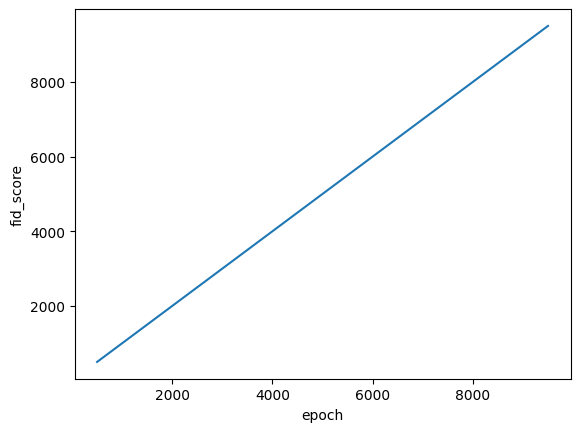

In [2]:
plt.figure()
plt.plot(np.arange(500, (10000), 500), np.arange(500, (10000), 500))
plt.xlabel('epoch')
plt.ylabel('fid_score')
plt.show()

In [4]:
np.arange(500, (10001), 500)

array([  500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,  4500,
        5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,  9000,
        9500, 10000])